In [ ]:
!kaggle datasets download -d imadeddinedjerarda/mrl-eye-dataset

In [ ]:
!unzip /kaggle/working/mrl-eye-dataset.zip -d /kaggle/working/mrleyedataset

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np

In [ ]:
!pip install wurlitzer

In [ ]:
!pip install numpy==1.25.2
!pip install pandas==2.0.3
!pip install matplotlib==3.7.1
!pip install tensorflow==2.15.0

In [3]:
class GrayscaleToRGBDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, target_size, color_mode, subset=None, validation_split=None):
        self.batch_size = batch_size
        self.target_size = target_size
        self.color_mode = color_mode
        self.subset = subset
        self.validation_split = validation_split
        self.directory = directory
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=validation_split
        )
        self.generator = self.datagen.flow_from_directory(
            directory=self.directory,
            target_size=self.target_size,
            batch_size=self.batch_size,
            color_mode=self.color_mode,
            class_mode='binary',
            subset=self.subset
        )
        self.samples = self.generator.samples
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(self.samples / self.batch_size))

    def __getitem__(self, index):
        batch_x, batch_y = self.generator[index]
        if self.color_mode == 'grayscale':
            batch_x = np.repeat(batch_x, 3, axis=-1)
        return batch_x, batch_y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

In [4]:
train_datagen = GrayscaleToRGBDataGenerator(
    directory='/kaggle/working/mrleyedataset/mrleyedataset',
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',
    subset='training',
    validation_split=0.2
)

Found 67919 images belonging to 2 classes.


In [5]:
validation_datagen = GrayscaleToRGBDataGenerator(
    directory='/kaggle/working/mrleyedataset/mrleyedataset',
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',
    subset='validation',
    validation_split=0.2
)

Found 16979 images belonging to 2 classes.


In [6]:
# Calculate steps per epoch
steps_per_epoch = len(train_datagen)
validation_steps = len(validation_datagen)

In [7]:
validation_steps

531

In [8]:
steps_per_epoch

2123

In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [10]:
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [13]:
model.fit(
    train_datagen,
    epochs=20,
    validation_data=validation_datagen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/20


I0000 00:00:1721577123.694805    1395 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2123/2123 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9817

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2123/2123 [==============================] - 495s 219ms/step - loss: 0.0516 - accuracy: 0.9817 - val_loss: 0.4188 - val_accuracy: 0.9105 - lr: 1.0000e-04
Epoch 2/20
2123/2123 [==============================] - 472s 222ms/step - loss: 0.0320 - accuracy: 0.9893 - val_loss: 0.1756 - val_accuracy: 0.9592 - lr: 1.0000e-04
Epoch 3/20
2123/2123 [==============================] - 454s 214ms/step - loss: 0.0273 - accuracy: 0.9903 - val_loss: 0.3017 - val_accuracy: 0.9407 - lr: 1.0000e-04
Epoch 4/20
2123/2123 [==============================] - 460s 217ms/step - loss: 0.0254 - accuracy: 0.9910 - val_loss: 0.3629 - val_accuracy: 0.9296 - lr: 1.0000e-04
Epoch 5/20
2123/2123 [==============================] - 456s 215ms/step - loss: 0.0231 - accuracy: 0.9916 - val_loss: 0.3467 - val_accuracy: 0.9321 - lr: 1.0000e-04
Epoch 6/20
2123/2123 [==============================] - 460s 216ms/step - loss: 0.0214 - accuracy: 0.9923 - val_loss: 0.4311 - val_accuracy: 0.9294 - lr: 1.0000e-04
Epoch 7/20
2123/2123 

In [14]:
# Save the model
model.save('drowsiness_detection_model.h5')

In [21]:
from IPython.display import display, Javascript
#from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from tensorflow.keras.models import load_model

In [ ]:

# Load the trained model
model = load_model('/kaggle/working/drowsiness_detection_model.h5')

In [ ]:
# # Function to take a photo using the webcam
# def take_photo(filename='photo.jpg', quality=0.8):
#     js = Javascript('''
#         async function takePhoto(quality) {
#             const div = document.createElement('div');
#             const capture = document.createElement('button');
#             capture.textContent = 'Capture';
#             div.appendChild(capture);

#             const video = document.createElement('video');
#             video.style.display = 'block';
#             const stream = await navigator.mediaDevices.getUserMedia({video: true});

#             document.body.appendChild(div);
#             div.appendChild(video);
#             video.srcObject = stream;
#             await video.play();

#             // Resize the output to fit the video element.
#             google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

#             // Wait for Capture to be clicked.
#             await new Promise((resolve) => capture.onclick = resolve);

#             const canvas = document.createElement('canvas');
#             canvas.width = video.videoWidth;
#             canvas.height = video.videoHeight;
#             canvas.getContext('2d').drawImage(video, 0, 0);
#             stream.getVideoTracks()[0].stop();
#             div.remove();
#             return canvas.toDataURL('image/jpeg', quality);
#         }
#     ''')
#     display(js)
#     data = eval_js('takePhoto({})'.format(quality))
#     binary = b64decode(data.split(',')[1])
#     with open(filename, 'wb') as f:
#         f.write(binary)
#     return filename

In [15]:
!kaggle datasets download -d jyotilalwani/drowsinessdetectionimg

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/jyotilalwani/drowsinessdetectionimg
License(s): unknown
  0%|                                               | 0.00/57.5k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 57.5k/57.5k [00:00<00:00, 69.0MB/s]


In [16]:
!unzip /kaggle/working/drowsinessdetectionimg.zip -d /kaggle/working/drowsinessdetectionimg

Archive:  /kaggle/working/drowsinessdetectionimg.zip
  inflating: /kaggle/working/drowsinessdetectionimg/ClosedEyes_bw.jpg  
  inflating: /kaggle/working/drowsinessdetectionimg/OpenEyes_BW.jpg  


In [ ]:
# # Capture a photo
# photo_filename = take_photo()

In [17]:
# Directory containing the images
image_directory = '/kaggle/working/drowsinessdetectionimg'

In [22]:
# Load Haar cascade for face and eye detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [23]:
# Function to preprocess the eye image
def preprocess_eye(eye_img):
    eye_img = cv2.resize(eye_img, (224, 224))
    eye_img = cv2.cvtColor(eye_img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
    eye_img = eye_img / 255.0
    eye_img = np.expand_dims(eye_img, axis=0)
    return eye_img

In [ ]:
# # Function to preprocess the eye image
# def preprocess_eye(eye_img):
#     eye_img = cv2.resize(eye_img, (224, 224))  # Resize the image to 224x224
#     eye_img = eye_img / 255.0  # Normalize the image
#     eye_img = np.expand_dims(eye_img, axis=0)  # Add batch dimension
#     return eye_img

In [ ]:
# Load the captured image
image = cv2.imread(photo_filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

In [28]:
import os
import cv2
import numpy as np
from IPython.display import display, Image
from tensorflow.keras.models import load_model

1/1 [==============================] - 0s 23ms/step


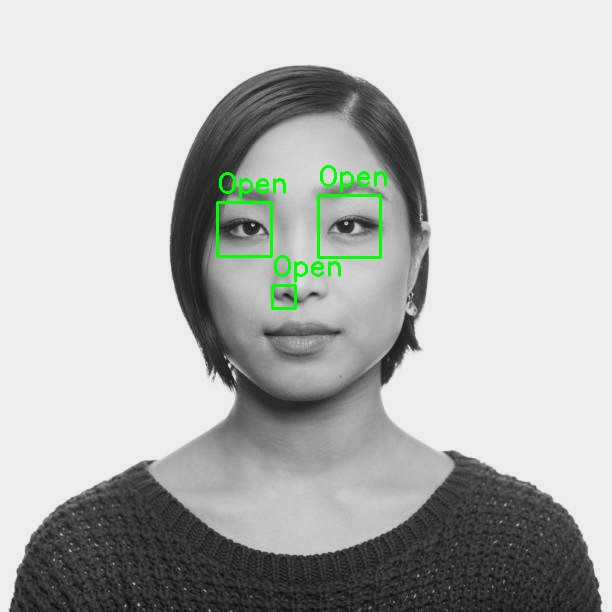

1/1 [==============================] - 0s 22ms/step


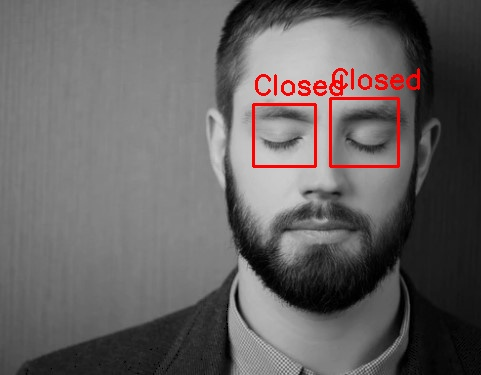

In [29]:
# Loop through all .jpg files in the directory
for filename in os.listdir(image_directory):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_directory, filename)
        
        # Load the captured image
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = image[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)

            for (ex, ey, ew, eh) in eyes:
                eye = roi_gray[ey:ey+eh, ex:ex+ew]  # Get the grayscale eye image
                eye_img = preprocess_eye(eye)  # Preprocess the eye image
                prediction = model.predict(eye_img)

                if prediction < 0.5:  # Assuming 0.5 as the threshold for closed eyes
                    color = (0, 0, 255)  # Red for closed eyes
                    cv2.putText(roi_color, "Closed", (ex, ey-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
                else:
                    color = (0, 255, 0)  # Green for open eyes
                    cv2.putText(roi_color, "Open", (ex, ey-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

                cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), color, 2)

        # Save the result image
        result_path = os.path.join('/kaggle/working', 'result_' + filename)
        cv2.imwrite(result_path, image)
        
        # Display the result
        display(Image(filename=result_path))